<a href="https://colab.research.google.com/github/humeraaa/Training-Workshop-at-JUW/blob/master/mnist123.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Flatten, MaxPooling2D
from keras.layers.convolutional import Conv2D 
from keras.utils import np_utils
from keras import backend as K

from distutils.version import LooseVersion as LV
from keras import __version__

from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

print('Using Keras version:', __version__, 'backend:', K.backend())
assert(LV(__version__) >= LV("2.0.0"))

Using TensorFlow backend.


Using Keras version: 2.2.4 backend: tensorflow


Let's load the MNIST or Fashion-MNIST dataset.

In [3]:
from keras.datasets import mnist, fashion_mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()
#(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
nb_classes = 10

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

# one-hot encoding:
Y_train = np_utils.to_categorical(y_train, nb_classes)
Y_test = np_utils.to_categorical(y_test, nb_classes)

print()
print('MNIST data loaded: train:',len(X_train),'test:',len(X_test))
print('X_train:', X_train.shape)
print('y_train:', y_train.shape)
print('Y_train:', Y_train.shape)

11493376/11490434 [==============================] - 1s 0us/step

MNIST data loaded: train: 60000 test: 10000
X_train: (60000, 28, 28)
y_train: (60000,)
Y_train: (60000, 10)


We'll have to do a bit of tensor manipulations, depending on the used backend (Theano or Tensorflow).

In [4]:
# input image dimensions
img_rows, img_cols = 28, 28

if K.image_dim_ordering() == 'th':
    X_train = X_train.reshape(X_train.shape[0], 1, img_rows, img_cols)
    X_test = X_test.reshape(X_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X_train = X_train.reshape(X_train.shape[0], img_rows, img_cols, 1)
    X_test = X_test.reshape(X_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)
    
print('X_train:', X_train.shape)

X_train: (60000, 28, 28, 1)


Initialization
Now we are ready to create a convolutional model.

The Convolution2D layers operate on 2D matrices so we input the digit images directly to the model.
The MaxPooling2D layer reduces the spatial dimensions, that is, makes the image smaller.
The Flatten layer flattens the 2D matrices into vectors, so we can then switch to Dense layers as in the MLP model.
See https://keras.io/layers/convolutional/, https://keras.io/layers/pooling/ for more information.

In [6]:
# number of convolutional filters to use
nb_filters = 32
# convolution kernel size
kernel_size = (3, 3)
# size of pooling area for max pooling
pool_size = (2, 2)

model = Sequential()

model.add(Conv2D(nb_filters, kernel_size,
                 padding='valid',
                 input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, kernel_size))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=pool_size))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(units=128))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(units=nb_classes))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_3 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
activation_5 (Activation)    (None, 26, 26, 32)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
activation_6 (Activation)    (None, 24, 24, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 12, 12, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 4608)              0         
__________

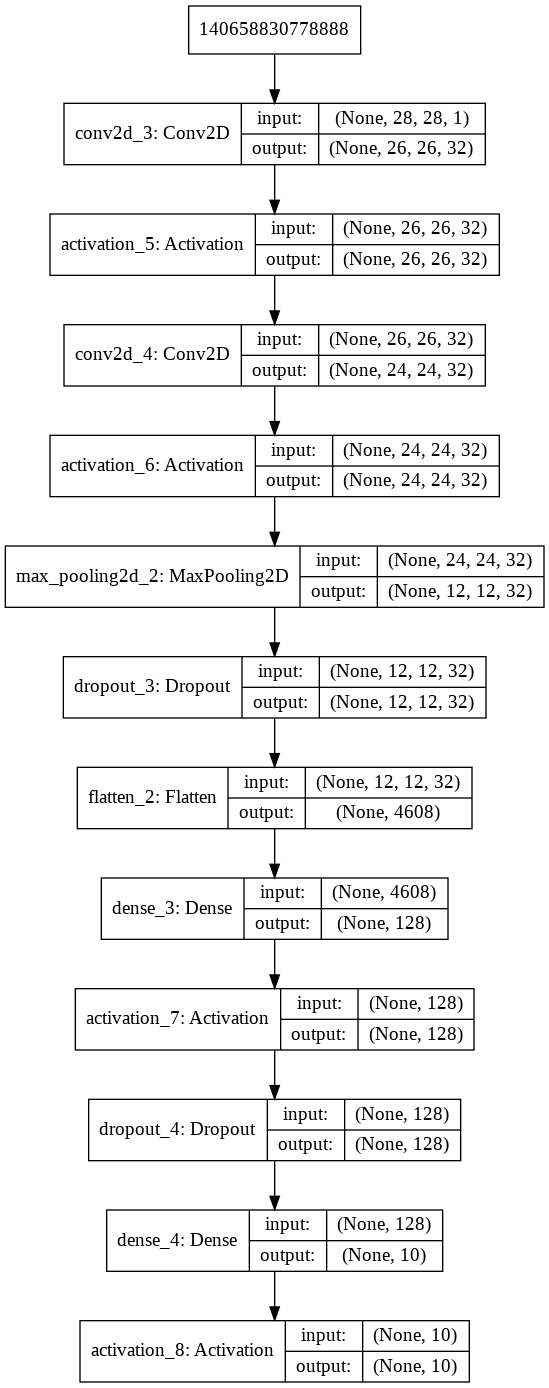

In [7]:
from keras.utils.vis_utils import plot_model
from IPython.display import Image

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
Image(filename='model_plot.png') 

**Learning**
Now let's train the CNN model. Note that we do not need the reshape() function as in the MLP case.

This is a relatively complex model, so training is considerably slower than with MLPs.

In [8]:
%time

epochs = 5 # one epoch takes about 45 seconds

history = model.fit(X_train, 
                    Y_train, 
                    epochs=epochs, 
                    batch_size=128,
                    verbose=2)

CPU times: user 4 µs, sys: 1 µs, total: 5 µs
Wall time: 9.3 µs
Epoch 1/5
 - 115s - loss: 0.2337 - acc: 0.9297
Epoch 2/5
 - 112s - loss: 0.0873 - acc: 0.9740
Epoch 3/5
 - 128s - loss: 0.0675 - acc: 0.9803
Epoch 4/5
 - 115s - loss: 0.0567 - acc: 0.9838
Epoch 5/5
 - 115s - loss: 0.0524 - acc: 0.9843


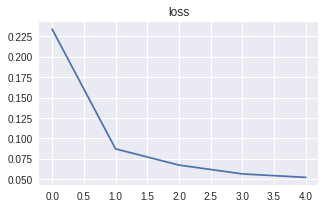

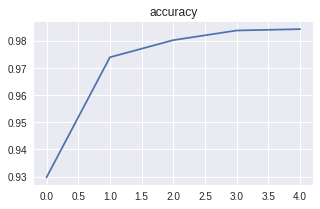

In [9]:
plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['loss'])
plt.title('loss')

plt.figure(figsize=(5,3))
plt.plot(history.epoch,history.history['acc'])
plt.title('accuracy');

**Inference**
With enough training epochs, the test accuracy should exceed 99%.

You can compare your result with the state-of-the art here. Even more results can be found here.

In [10]:
%%time
scores = model.evaluate(X_test, Y_test, verbose=2)
print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

acc: 98.92%
CPU times: user 9.26 s, sys: 287 ms, total: 9.55 s
Wall time: 5.18 s


In [0]:
def show_failures(predictions, trueclass=None, predictedclass=None, maxtoshow=10):
    rounded = np.argmax(predictions, axis=1)
    errors = rounded!=y_test
    print('Showing max', maxtoshow, 'first failures. '
          'The predicted class is shown first and the correct class in parenthesis.')
    ii = 0
    plt.figure(figsize=(maxtoshow, 1))
    for i in range(X_test.shape[0]):
        if ii>=maxtoshow:
            break
        if errors[i]:
            if trueclass is not None and y_test[i] != trueclass:
                continue
            if predictedclass is not None and predictions[i] != predictedclass:
                continue
            plt.subplot(1, maxtoshow, ii+1)
            plt.axis('off')
            if K.image_dim_ordering() == 'th':
                plt.imshow(X_test[i,0,:,:], cmap="gray")
            else:
                plt.imshow(X_test[i,:,:,0], cmap="gray")
            plt.title("%d (%d)" % (rounded[i], y_test[i]))
            ii = ii + 1

Here are the first 10 test digits the CNN classified to a wrong class:

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


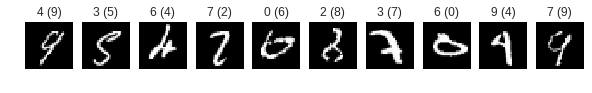

In [13]:
predictions = model.predict(X_test)

show_failures(predictions)

Showing max 10 first failures. The predicted class is shown first and the correct class in parenthesis.


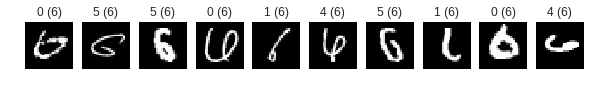

In [14]:
show_failures(predictions, trueclass=6)